In [1]:
# ! pip install ipympl


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 데이터 로딩 및 전처리

In [3]:
# 예시 경로, 실제 경로로 수정 필요

# 게임에 참가한 사람들의 고유 정보
participants = pd.read_csv("data/top1000/participants.csv")
# 시간 흐름에 따라 변화하는 실시간 스탯 (골드, 딜량 등) 
participants_frames = pd.read_csv("data/top1000/participant_frames.csv")
# 게임 단위의 결과 (승패 등)
matches = pd.read_csv("data/top1000/matches.csv")
# 킬 이벤트 정보 (누가 누구를 죽였는지)
champ_kill = pd.read_csv('data/top1000/events__CHAMPION_KILL.csv')

In [4]:
# 가장 마지막 프레임만 사용 (게임 종료 시점 상태)
# 게임 종료 시점 기준으로 정보 하나로 묶기
latest_frames = participants_frames.sort_values("frame_timestamp").drop_duplicates(
    subset=["game_id", "participant_id"], keep='last'
)

merged_df = pd.merge(participants, latest_frames, on=["game_id", "participant_id"], how="left")

In [5]:
# participants, latest_frames, matches 병합

merged_df = pd.merge(merged_df, matches[["game_id", "end_of_game_result"]], on="game_id", how="left")
merged_df.head()

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,physicalDamageDone,physicalDamageDoneToChampions,physicalDamageTaken,totalDamageDone,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken,end_of_game_result
0,7586549521,1,T2coi9U5HI63yttsRxRgUeQ2xLzedwMv0LWMV_Xtp812gj...,1956361,3780,0,4,18,236,227461,...,194329,25468,29526,221039,38637,35625,26709,13168,3156,GameComplete
1,7586549521,2,VzxkuEt2Ay_6P_1wY1FajjdMW8ty20cPLb0jmwqAAjA9Ns...,1956361,1597,0,142,17,22,171344,...,179288,21128,32491,251617,26859,44796,65212,2829,2577,GameComplete
2,7586549521,3,-jMFYAy4ogcmItoiwYmQX7tG2fB59CvKQieQwZqYvcLw1x...,1956361,2454,0,8,17,232,259989,...,7663,1838,21349,206296,37478,31216,7563,1790,3254,GameComplete
3,7586549521,4,CDtqv-NZS5cmtQI0bsfbxBhq29QlqmwX_YwgG5oW3PkhMm...,1956361,1339,0,16,18,199,130050,...,142170,22574,20998,217726,47278,33657,9483,2649,782,GameComplete
4,7586549521,5,72aXoGzHe_SjiP1hNKnMXyx_UYND4_HE2j1Awp9E3l6pge...,1956361,1189,50,0,14,15,226379,...,5571,3723,21177,17701,12926,36143,3208,2008,2392,GameComplete


In [6]:
merged_df.columns

Index(['game_id', 'participant_id', 'puuid', 'frame_timestamp', 'current_gold',
       'gold_per_second', 'jungle_minions_killed', 'level', 'minions_killed',
       'time_enemy_spent_controlled', 'total_gold', 'xp', 'position_x',
       'position_y', 'abilityhaste', 'abilitypower', 'armor', 'armorpen',
       'armorpenpercent', 'attackdamage', 'attackspeed',
       'bonusarmorpenpercent', 'bonusmagicpenpercent', 'ccreduction',
       'cooldownreduction', 'health', 'healthmax', 'healthregen', 'lifesteal',
       'magicpen', 'magicpenpercent', 'magicresist', 'movementspeed',
       'omnivamp', 'physicalvamp', 'power', 'powermax', 'powerregen',
       'spellvamp', 'magicDamageDone', 'magicDamageDoneToChampions',
       'magicDamageTaken', 'physicalDamageDone',
       'physicalDamageDoneToChampions', 'physicalDamageTaken',
       'totalDamageDone', 'totalDamageDoneToChampions', 'totalDamageTaken',
       'trueDamageDone', 'trueDamageDoneToChampions', 'trueDamageTaken',
       'end_of_game_

## 2. KDA 및 주요 파생 지표 생성

### KDA 계산

컬럼 | 의미
---- | ----
kills | 해당 경기에서 몇 번 킬 했는가
deaths | 몇 번 죽었는가
assists | 어시스트 수
KDA | (킬 + 어시스트) / 데스 (생존 기반 전투 영향력)

In [7]:
# kills 수 계산 (킬한 사람 기준)
kills = champ_kill.groupby(["game_id", "killer_id"]).size().reset_index(name="kills")
kills.rename(columns={"killer_id": "participant_id"}, inplace=True)

In [8]:
# deaths 수 계산 (죽은 사람 기준)
deaths = champ_kill.groupby(["game_id", "victim_id"]).size().reset_index(name="deaths")
deaths.rename(columns={"victim_id": "participant_id"}, inplace=True)

In [9]:
# assists 수 계산
assist_df = pd.read_csv("data/top1000/event_assists.csv")

# 게임 ID + 어시스트 참가자 ID로 그룹화
assists = assist_df.groupby(["game_id", "participant_id"]).size().reset_index(name="assists")


In [10]:
# KDA 구하기

# 기본 participant list (merged_df)에서 가져오자
kda_base = merged_df[["game_id", "participant_id", "puuid"]].drop_duplicates()

# 병합
kda_df = (
    kda_base
    .merge(kills, on=["game_id", "participant_id"], how="left")
    .merge(deaths, on=["game_id", "participant_id"], how="left")
)

# 어시스트 컬럼 있으면 병합
if 'assists' in locals():
    kda_df = kda_df.merge(assists, on=["game_id", "participant_id"], how="left")

# 결측값 0으로 채우기
kda_df[["kills", "deaths", "assists"]] = kda_df[["kills", "deaths", "assists"]].fillna(0).astype(int)

# KDA 계산
# 분모가 0이 되면 오류가 나기 때문에, 완벽 생존은 1로 나눈 값을 최대치로 보정
kda_df["KDA"] = (kda_df["kills"] + kda_df["assists"]) / kda_df["deaths"].replace(0, 1)


In [11]:
# merged_df에 병합

merged_df = pd.merge(merged_df, kda_df[["game_id", "participant_id", "kills", "deaths", "assists", "KDA"]],
                     on=["game_id", "participant_id"], how="left")
merged_df.head()

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken,end_of_game_result,kills,deaths,assists,KDA
0,7586549521,1,T2coi9U5HI63yttsRxRgUeQ2xLzedwMv0LWMV_Xtp812gj...,1956361,3780,0,4,18,236,227461,...,38637,35625,26709,13168,3156,GameComplete,13,3,19,10.666667
1,7586549521,2,VzxkuEt2Ay_6P_1wY1FajjdMW8ty20cPLb0jmwqAAjA9Ns...,1956361,1597,0,142,17,22,171344,...,26859,44796,65212,2829,2577,GameComplete,12,10,14,2.600000
2,7586549521,3,-jMFYAy4ogcmItoiwYmQX7tG2fB59CvKQieQwZqYvcLw1x...,1956361,2454,0,8,17,232,259989,...,37478,31216,7563,1790,3254,GameComplete,4,11,19,2.090909
3,7586549521,4,CDtqv-NZS5cmtQI0bsfbxBhq29QlqmwX_YwgG5oW3PkhMm...,1956361,1339,0,16,18,199,130050,...,47278,33657,9483,2649,782,GameComplete,16,11,15,2.818182
4,7586549521,5,72aXoGzHe_SjiP1hNKnMXyx_UYND4_HE2j1Awp9E3l6pge...,1956361,1189,50,0,14,15,226379,...,12926,36143,3208,2008,2392,GameComplete,2,15,23,1.666667


## 유사도 기반 파생 지표 생성 (예시: 시야 점수, 미니언 수, 골드 등)

### 성장 및 경제 지표        

| 지표 | 의미 | 해석 |  
| ---- | ---- | ---- |   
| CS/Min | 분당 미니언 수급량 | 파밍 능력 |     
| Gold/Min | 분당 골드 | 성장 속도 |        
| XP/Min | 분당 경험치 | 레벨 성장 속도 |       




In [12]:
# 성장 및 경제 지표
# CS (미니언 + 정글)
merged_df["cs"] = merged_df["minions_killed"] + merged_df["jungle_minions_killed"]

# 분당 CS
merged_df["cs_per_min"] = merged_df["cs"] / (merged_df["frame_timestamp"] / 60000)

# 분당 골드
merged_df["gold_per_min"] = merged_df["total_gold"] / (merged_df["frame_timestamp"] / 60000)

# 분당 경험치
merged_df["xp_per_min"] = merged_df["xp"] / (merged_df["frame_timestamp"] / 60000)

### 전투 능력 지표

지표 | 의미 | 해석
---- | ---- | ----
Damage/Min | 분당 딜량 | 전투 기여도
Damage Taken/Min | 분당 받은 피해 | 탱킹 능력 또는 위험 노출
KA/Min | 분당 킬 관여 수 | 싸움 참여율 (적극적인지 여부)
Damage Efficiency | 피해 교환 비율 | 딜 효율 (딜을 얼마나 잘 넣고 덜 맞았는지)

In [13]:
# 전투력 관련 지표
# 분당 피해량
merged_df["damage_per_min"] = merged_df["totalDamageDoneToChampions"] / (merged_df["frame_timestamp"] / 60000)

# 분당 받은 피해량
merged_df["damage_taken_per_min"] = merged_df["totalDamageTaken"] / (merged_df["frame_timestamp"] / 60000)

# 분당 킬 관여율 (K+A)/시간
merged_df["ka_per_min"] = (merged_df["kills"] + merged_df["assists"]) / (merged_df["frame_timestamp"] / 60000)

# 피해 교환 효율 (딜량 / 받은 피해량)
merged_df["damage_efficiency"] = merged_df["totalDamageDoneToChampions"] / merged_df["totalDamageTaken"].replace(0, 1)


### 생존력 지표

지표 | 의미 | 해석
---- | ---- | ----
survivability | 생존률 | 
healthregen_per_min | 분당 체력 재생 | 


In [14]:
# 생존력 지표
# 생존률 (1 - 데스 / 평균 생존시간) → 데스 적을수록 높음
merged_df["survivability"] = 1 / merged_df["deaths"].replace(0, 1)

# 분당 체력 재생
merged_df["healthregen_per_min"] = merged_df["healthregen"] / (merged_df["frame_timestamp"] / 60000)


### 시야 장악 지표

지표 | 의미 | 해석
---- | ---- | ----
Wards Placed/Min | 분당 설치 | 시야 제공 적극성
Wards Killed/Min | 분당 제거 | 상대 시야 차단 능력
Vision Score Est. | 설치+제거 총합 | 시야 장악 종합 평가 (approx.)

In [15]:
# 포지션 제어 / 시야 장악 지표
wards_placed = pd.read_csv("data/top1000/events__WARD_PLACED.csv")
wards_killed = pd.read_csv("data/top1000/events__WARD_KILL.csv")

## 와드 설치 수
ward_placed_count = (
    wards_placed
    .groupby(["game_id", "creator_id"])
    .size()
    .reset_index(name="wards_placed")
    .rename(columns={"creator_id": "participant_id"})
)

## 와드 제거 수
ward_kill_count = (
    wards_killed
    .groupby(["game_id", "killer_id"])
    .size()
    .reset_index(name="wards_killed")
    .rename(columns={"killer_id": "participant_id"})
)

## merged_df에 와드 수 붙이기
merged_df = (
    merged_df
    .merge(ward_placed_count, on=["game_id", "participant_id"], how="left")
    .merge(ward_kill_count, on=["game_id", "participant_id"], how="left")
)

# 결측치는 0으로 처리
merged_df[["wards_placed", "wards_killed"]] = merged_df[["wards_placed", "wards_killed"]].fillna(0).astype(int)

## 시야 제어 파생 지표 추가
# 분당 와드 설치
merged_df["wards_placed_per_min"] = merged_df["wards_placed"] / (merged_df["frame_timestamp"] / 60000)

# 분당 와드 제거
merged_df["wards_killed_per_min"] = merged_df["wards_killed"] / (merged_df["frame_timestamp"] / 60000)

# 종합 시야 지표 (설치 + 제거)
merged_df["vision_score_est"] = merged_df["wards_placed"] + merged_df["wards_killed"]


### 종합 능력치 지표
기본 아이템 + 능력치 요약

In [16]:
# 아이템/스탯 관련 종합 능력치
# 전체 공격 스탯
merged_df["offensive_score"] = merged_df["attackdamage"] + merged_df["attackspeed"]

# 전체 방어 스탯
merged_df["defensive_score"] = merged_df["armor"] + merged_df["magicresist"]

# 전체 마법 능력치
merged_df["magic_score"] = merged_df["abilitypower"] + merged_df["magicpen"] + merged_df["magicpenpercent"]


생존 또는 스킬 활용 능력

In [17]:
# 기타 유틸성 스탯
# 만능 흡혈 + 물리 흡혈 + 주문 흡혈
merged_df["total_vamp"] = merged_df[["omnivamp", "physicalvamp", "spellvamp"]].sum(axis=1)

# 스킬 쿨다운 영향력
merged_df["haste_score"] = merged_df["cooldownreduction"] + merged_df["abilityhaste"]


## 3. 상위 1000명 필터링 및 일반 유저 선택

In [18]:
# # Top 1000 유저 필터링
# top1000_puuids = merged_df.sort_values("KDA", ascending=False)["puuid"].unique()[:1000]
# merged_df["is_top1000"] = merged_df["puuid"].isin(top1000_puuids)


In [19]:
# # 상위 1000명의 유저와 아닌 유저 분리
# df_top = merged_df[merged_df["is_top1000"] == True].copy()
# df_user = merged_df[merged_df["is_top1000"] == False].copy()


# 유사도 분석
- 일반 유저와 Top1000 유저 간의 유사도를 수치로 계산
- 가장 유사한 상위 10~20명을 추출

## 유사도 계산용 피처 선택
- 유저의 게임 스타일을 구성하는 성능 지표

카테고리 | 예시 지표 | 의미
------ | ------- | ----
성장 | CS/Min, Gold/Min, XP/Min | 파밍 능력
전투 | KDA, KA/Min, Damage | 교전 참여도
생존 | Survivability, Damage Efficiency | 얼마나 잘 살아남는가
능력치 | offensive_score 등 | 스탯 종합
시야 | wards_placed_per_min 등 | 맵 컨트롤 능력

In [20]:
features = [
    "KDA", "cs_per_min", "gold_per_min", "xp_per_min",
    "damage_per_min", "damage_taken_per_min", "ka_per_min", "damage_efficiency",
    "survivability", "healthregen_per_min",
    "offensive_score", "defensive_score", "magic_score", "total_vamp", "haste_score",
    "wards_placed_per_min", "wards_killed_per_min", "vision_score_est"
]


## 정규화 (Standard Scaler)
- 모든 feature는 단위와 크기가 다르기 때문에, 정규화를 하지 않으면 왜곡된 유사도가 계산

In [21]:
from sklearn.preprocessing import StandardScaler

# 상위 유저 데이터만 추출
# X_top = merged_df[merged_df["is_top1000"] == True][features].fillna(0)
X_top = merged_df[features].fillna(0)

# 일반 유저 하나 선택 (예: puuid 기반)
# target_puuid = df_user['puuid'].sample(1).values[0]
target_puuid = '1nry226Ys8jmA4IrYNRAqBOLA09dO_oisz6Din8AyUOowu80Mp3ggYKg3moP6BbiDD8d8fw9t-3IVw' 
X_target = merged_df[merged_df["puuid"] == target_puuid][features].fillna(0)
X_target = pd.DataFrame(X_target.mean()).T

# 스케일링
scaler = StandardScaler()
scaler.fit(pd.concat([X_top, X_target]))  # 전체 기준으로 학습
X_top_scaled = scaler.transform(X_top)
X_target_scaled = scaler.transform(X_target)

## 유사도 계산 (Cosine Similarity)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# 유사도 계산
similarities = cosine_similarity(X_target_scaled, X_top_scaled)[0]  # 1행으로 나온 값


## 유사도 상위 유저 추출

In [23]:
# 상위 유저 리스트 가져오기
# top_players = merged_df[merged_df["is_top1000"] == True][["puuid", "game_id", "participant_id"]].drop_duplicates()
top_players = merged_df[["puuid", "game_id", "participant_id"]].drop_duplicates()

# 유사도 결과와 합치기
top_players["similarity"] = similarities

# 상위 10명 추출
top_similar_players = top_players.sort_values("similarity", ascending=False)[1:].head(10)


In [24]:
# 유사도(similarity)가 높은 상위 유저 10명 추출
print(top_similar_players[["puuid", "game_id", "participant_id", "similarity"]])


                                                  puuid     game_id  \
5380  Sbed50Dd8jbsS16DyN5nYk4dHNf1zZlI1qOzRCFjkvK-CV...  7587138891   
4315  4O9vRHBah1PpackSuIHoGnK2umwSOWFgAZB82w9uORFEHZ...  7587477048   
2480  9E5g5a9GWLUBcpAOwJV5dSm2Cyn5j93DlWQiDS8ruAUKaf...  7587625177   
675   VDM50cD1Mq4lkLyJfO1T6sxv08g2A67bapjXBfB6W2C9FS...  7587499452   
6675  Uo0hxkcCypnpyuxTVdsn7mOsGwn0a8Q9o9BDu66lxRjaYL...  7585861538   
1740  bovEA0GShcixkdwc4Gia_fCvUt4RoU4UFqgSl22Uu0eCve...  7587467217   
5807  U7dR2JIA3B4sbEQENjHsebCqLAtHt9imdfDBYwK5eEGNif...  7586758073   
4290  8NzZY9uRkJLxRd_9mS4ywZMn1KQoZ6xg6HmtnvkYJ-P6NW...  7587487421   
1395  0pPRbUmtyh5uHUddRmpkloWRSYTNwYEGKNiCxyHr2T_eLZ...  7587606902   
2395  Sq5iuY61JQKIVMQMDIdIRRAb0CvHNiHCBPOUb0IglfV0LV...  7585977639   

      participant_id  similarity  
5380               1    0.871049  
4315               6    0.846763  
2480               1    0.836417  
675                6    0.830912  
6675               6    0.823223  
1740    

## 데이터 추출

In [25]:
# export_df = top_similar_players[["puuid", "game_id", "participant_id", "similarity"]]

In [26]:
# export_df.to_csv("top_similar_users.csv", index=False)


## 데이터 시각화

### 2차원 좌표 생성 (PCA or t-SNE)

In [27]:
from sklearn.decomposition import PCA

# 해당 유저들만 필터링
similar_puuids = top_similar_players["puuid"].tolist()
X_vis = merged_df[merged_df["puuid"].isin(similar_puuids)][features].fillna(0)

# PCA로 2D 압축
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X_vis))

# 위치 + 메타데이터 결합
plot_df = merged_df[merged_df["puuid"].isin(similar_puuids)].copy()
plot_df = plot_df.reset_index(drop=True)
plot_df["x"] = X_pca[:, 0]
plot_df["y"] = X_pca[:, 1]


In [28]:
# similarity 정보 복원
similarity_map = top_similar_players.set_index("puuid")["similarity"].to_dict()
plot_df["similarity"] = plot_df["puuid"].map(similarity_map)


### matplotlib + interactive 클릭 이벤트 시각화

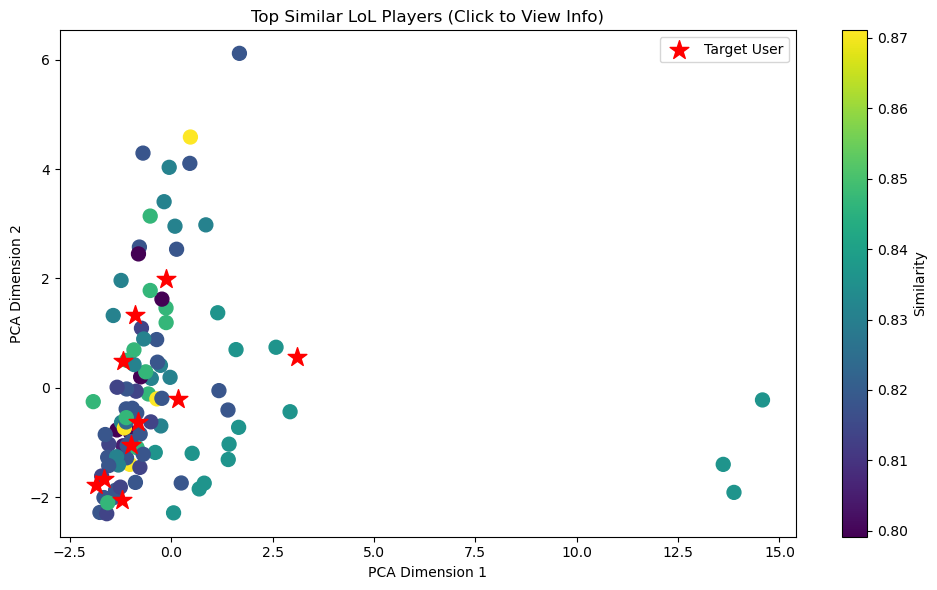

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(plot_df["x"], plot_df["y"], c=plot_df["similarity"], cmap="viridis", s=100)

# 텍스트 박스 준비
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    i = ind["ind"][0]
    row = plot_df.iloc[i]
    text = f"""PUUID: {row['puuid']}
                KDA: {row['KDA']:.2f}
                CS/Min: {row['cs_per_min']:.2f}
                Gold/Min: {row['gold_per_min']:.2f}
                Damage/Min: {row['damage_per_min']:.2f}
                Vision Score: {row['vision_score_est']}
                Similarity: {row['similarity']:.2f}
            """
    annot.xy = (row["x"], row["y"])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.9)

def on_click(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scatter.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", on_click)

# 기준 유저 좌표
target_row = merged_df[merged_df["puuid"] == target_puuid].copy()
target_scaled = scaler.transform(target_row[features].fillna(0))
target_pca = pca.transform(target_scaled)
ax.scatter(target_pca[:, 0], target_pca[:, 1], c="red", marker="*", s=200, label="Target User")
ax.legend()


plt.title("Top Similar LoL Players (Click to View Info)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar(scatter, label="Similarity")
plt.tight_layout()
plt.show()


### 상대적 거리 좌표 생성 (유사도 → 거리 변환)

In [30]:
import numpy as np

# 유사도 기반 거리 계산 (0~1 사이 → 가까울수록 유사함)
top_similar_players["distance"] = 1 - top_similar_players["similarity"]

# 간단한 원형 배치: 유사한 순서대로 각도를 나눠서 원 주변에 배치
angles = np.linspace(0, 2 * np.pi, len(top_similar_players), endpoint=False)
top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
top_similar_players["y"] = np.sin(angles) * top_similar_players["distance"]

# 파생 지표 붙이기 (중복 제거 주의!)
top_features = merged_df[["game_id", "participant_id", "KDA", "cs_per_min", "gold_per_min"]].copy()
top_similar_players = pd.merge(
    top_similar_players,
    top_features,
    on=["game_id", "participant_id"],
    how="left"
)

# 기준 유저 좌표 (항상 중심)
target_user_df = pd.DataFrame({
    "puuid": [target_puuid],
    "x": [0.0],
    "y": [0.0],
    "KDA": merged_df.loc[merged_df["puuid"] == target_puuid, "KDA"].values[0],
    "cs_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "cs_per_min"].values[0],
    "gold_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "gold_per_min"].values[0],
    "label": ["Target"]
})

# 상위 유저 + 타겟 유저 병합
top_similar_players["label"] = "Top"
plot_df = pd.concat([top_similar_players, target_user_df], ignore_index=True)


In [31]:
# import plotly.express as px

# # Plotly용 데이터 준비
# fig = px.scatter(
#     plot_df,
#     x="x", y="y",
#     color="similarity",
#     hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
#     text="label",
#     color_continuous_scale="Viridis",
#     title="Similarity-based Positioning (Target User = Center)"
# )

# # 기준 유저 강조 (색 없음, hover로만 표시됨)
# fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))

# fig.show()


### Plotly로 시각화

In [32]:
# 기준 유저 따로 빨간 점으로 표시
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px

# Plotly용 데이터 준비
fig = px.scatter(
    plot_df,
    x="x", y="y",
    color="similarity",
    hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
    text="label",
    color_continuous_scale="Viridis",
    title="Similarity-based Positioning (Target User = Center)"
)

# 기준 유저 강조 (색 없음, hover로만 표시됨)
fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))


target_trace = px.scatter(
    target_user_df,
    x="x", y="y",
    hover_data=["KDA", "cs_per_min", "gold_per_min"],
    text=["You"],
)

target_trace.update_traces(marker=dict(size=16, color='red', symbol='star'))
fig.add_trace(target_trace.data[0])


### 일반 유저 + 상위 유저 지표 비교 막대그래프 같이 그리기

In [33]:
import plotly.graph_objects as go
import pandas as pd

# 1. 기준 유저 게임 가져오기
user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
user_games = user_games.sort_values("game_id", ascending=False).head(10)

# 2. KDA 데이터 부족 시 채우기 (0으로)
kda_values = user_games["KDA"].tolist()
kda_values += [0] * (10 - len(kda_values))  # 10게임 채우기

# 3. x축 레이블
x_labels = [f"Game {i+1}" for i in range(10)]

# 4. Top 평균 KDA
# top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()
top_avg_kda = merged_df["KDA"].mean()

# 5. 그래프 생성
fig = go.Figure()

# 유저 KDA 막대
fig.add_trace(go.Bar(
    x=x_labels,
    y=kda_values,
    name="Target User KDA",
    marker_color='royalblue'
))

# Top 유저 평균 선
fig.add_trace(go.Scatter(
    x=x_labels,
    y=[top_avg_kda] * 10,
    name="Top Players Avg KDA",
    mode='lines',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title="Recent 10 Games KDA vs Top Player Avg KDA",
    xaxis_title="Game",
    yaxis_title="KDA",
    barmode='group',
    template='plotly_white'
)

fig.show()


### 유사도 순 정렬된 테이블 만들기

In [34]:
import pandas as pd
from IPython.display import display

display(
    plot_df[plot_df["label"] == "Top"]
    .sort_values("similarity", ascending=False)[
        ["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"]
    ]
)


,puuid,KDA,cs_per_min,gold_per_min,similarity
0,Sbed50Dd8jbsS16DyN5nYk4dHNf1zZlI1qOzRCFjkvK-CV...,3.000000,8.114984,423.224311,0.871049
1,4O9vRHBah1PpackSuIHoGnK2umwSOWFgAZB82w9uORFEHZ...,2.000000,7.868237,371.219400,0.846763
2,9E5g5a9GWLUBcpAOwJV5dSm2Cyn5j93DlWQiDS8ruAUKaf...,1.333333,8.528305,380.591529,0.836417
3,VDM50cD1Mq4lkLyJfO1T6sxv08g2A67bapjXBfB6W2C9FS...,2.333333,8.357076,401.557511,0.830912
4,Uo0hxkcCypnpyuxTVdsn7mOsGwn0a8Q9o9BDu66lxRjaYL...,2.666667,8.557373,417.480391,0.823223
5,bovEA0GShcixkdwc4Gia_fCvUt4RoU4UFqgSl22Uu0eCve...,2.500000,7.647446,415.759957,0.818461
6,U7dR2JIA3B4sbEQENjHsebCqLAtHt9imdfDBYwK5eEGNif...,1.500000,8.294136,372.796698,0.818059
7,8NzZY9uRkJLxRd_9mS4ywZMn1KQoZ6xg6HmtnvkYJ-P6NW...,3.333333,8.748685,411.579219,0.813644
8,0pPRbUmtyh5uHUddRmpkloWRSYTNwYEGKNiCxyHr2T_eLZ...,1.500000,8.017136,403.446957,0.804981
9,Sq5iuY61JQKIVMQMDIdIRRAb0CvHNiHCBPOUb0IglfV0LV...,2.000000,9.011926,398.397360,0.799170


In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import plotly.express as px

# 예시 데이터 생성
np.random.seed(0)
sample_size = 1000
feature_names = [
    "KDA",
    "cs_per_min",
    "gold_per_min",
    "xp_per_min",
    "damage_per_min",
    "damage_taken_per_min",
    "ka_per_min",
    "damage_efficiency",
    "survivability",
    "healthregen_per_min",
    "offensive_score",
    "defensive_score",
    "magic_score",
    "total_vamp",
    "haste_score",
    "wards_placed_per_min",
    "wards_killed_per_min",
    "vision_score_est",
]
X_full = pd.DataFrame(
    np.random.rand(sample_size, len(feature_names)), columns=feature_names
)
X_full["puuid"] = ["user_" + str(i) for i in range(sample_size)]

# 기준 유저 생성 (평균 기반)
target_puuid = "target_user"
X_target = pd.DataFrame(X_full[feature_names].mean()).T
X_target["puuid"] = target_puuid

# 전체 병합
X_all = pd.concat([X_full, X_target], ignore_index=True)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all[feature_names])

# 유사도 계산
similarities = cosine_similarity(X_scaled[-1].reshape(1, -1), X_scaled[:-1])[0]
X_full["similarity"] = similarities

# 유사도 Top 100명 추출
top_similar = X_full.sort_values("similarity", ascending=False).head(100).copy()

# PCA 변환
X_vis_scaled = scaler.transform(top_similar[feature_names])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis_scaled)
top_similar["x"] = X_pca[:, 0]
top_similar["y"] = X_pca[:, 1]

# 기준 유저 위치
target_scaled = scaler.transform(X_target[feature_names])
target_pca = pca.transform(target_scaled)
target_df = pd.DataFrame(
    {
        "puuid": [target_puuid],
        "x": [target_pca[0, 0]],
        "y": [target_pca[0, 1]],
        "similarity": [1.0],
    }
)

# 병합
plot_df = pd.concat(
    [top_similar[["puuid", "x", "y", "similarity"]], target_df], ignore_index=True
)

# Plotly 시각화
fig = px.scatter(
    plot_df,
    x="x",
    y="y",
    color="similarity",
    hover_data=["puuid", "similarity"],
    text="puuid",
    color_continuous_scale="Viridis",
    title="Similarity-based PCA Positioning (Target User Highlighted)",
)

# 기준 유저 강조
target_trace = px.scatter(
    target_df, x="x", y="y", hover_data=["similarity"], text=["You"]
)
target_trace.update_traces(marker=dict(size=16, color="red", symbol="star"))
fig.add_trace(target_trace.data[0])
fig.update_layout(height=600, width=900)
fig.show()